In [1]:
import os
import random

import pandas as pd       
import numpy as np  

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, median_absolute_error, mean_absolute_percentage_error

from scipy.stats import spearmanr

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.keras.losses import Loss

In [2]:
SEED = 42 

def set_seeds(seed: int = SEED) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    # When using the CuDNN backend (CUDA), two additional options must be configured.
    #os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"Random seed set as {seed}")

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

Random seed set as 42


# What about Data ?

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Mileem/PFIA_2024/main/data/raw/AAW.csv', delimiter=';', decimal=',', index_col=0, skiprows=[0]) 

df.head()

,Stress (Mpa),Fatigue life (cycles)
No.,,
1,294.3,5300
2,294.3,6200
3,294.3,6500
4,294.3,6600
5,294.3,7000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Stress (Mpa)           200 non-null    float64
 1   Fatigue life (cycles)  200 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


##  Converting to logarithm

In [5]:
df['stress_log_mpa'] = np.log(df['Stress (Mpa)'])
df['life_log'] = np.log(df['Fatigue life (cycles)'])

In [6]:
df.head()

,Stress (Mpa),Fatigue life (cycles),stress_log_mpa,life_log
No.,,,,
1,294.3,5300,5.6846,8.575462
2,294.3,6200,5.6846,8.732305
3,294.3,6500,5.6846,8.779557
4,294.3,6600,5.6846,8.794825
5,294.3,7000,5.6846,8.853665


## Visualisation des données

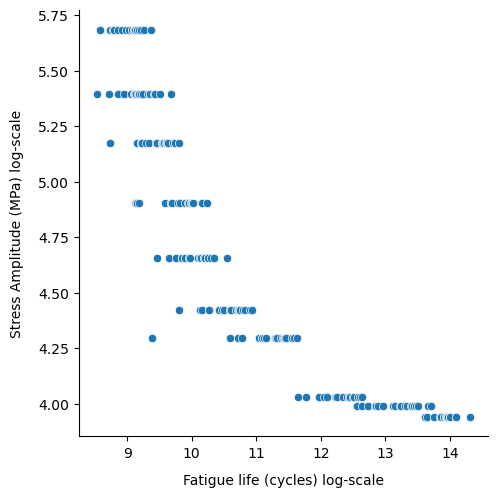

In [7]:
g = sns.relplot(data=df, x="life_log", y="stress_log_mpa")
g.set_axis_labels("Fatigue life (cycles) log-scale", "Stress Amplitude (MPa) log-scale", labelpad=10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Stress (Mpa)           200 non-null    float64
 1   Fatigue life (cycles)  200 non-null    int64  
 2   stress_log_mpa         200 non-null    float64
 3   life_log               200 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 7.8 KB


## Preprocessing

### Splitting data

In [9]:
x_train, x_val, y_train, y_val = train_test_split(df[['stress_log_mpa']].values, 
                                                  df['life_log'], test_size=0.3)

(x_train, x_val, y_train, y_val) = (tf.convert_to_tensor(x_train, dtype=tf.float32),tf.convert_to_tensor(x_val, dtype=tf.float32), 
 tf.convert_to_tensor(y_train, dtype=tf.float32), tf.convert_to_tensor(y_val, dtype=tf.float32))

### Creation of new data for testing

In [10]:
x_test = np.linspace(df['stress_log_mpa'].min(), 
                                      df['stress_log_mpa'].max()+0.01, 100).reshape(-1, 1)

### Visualize

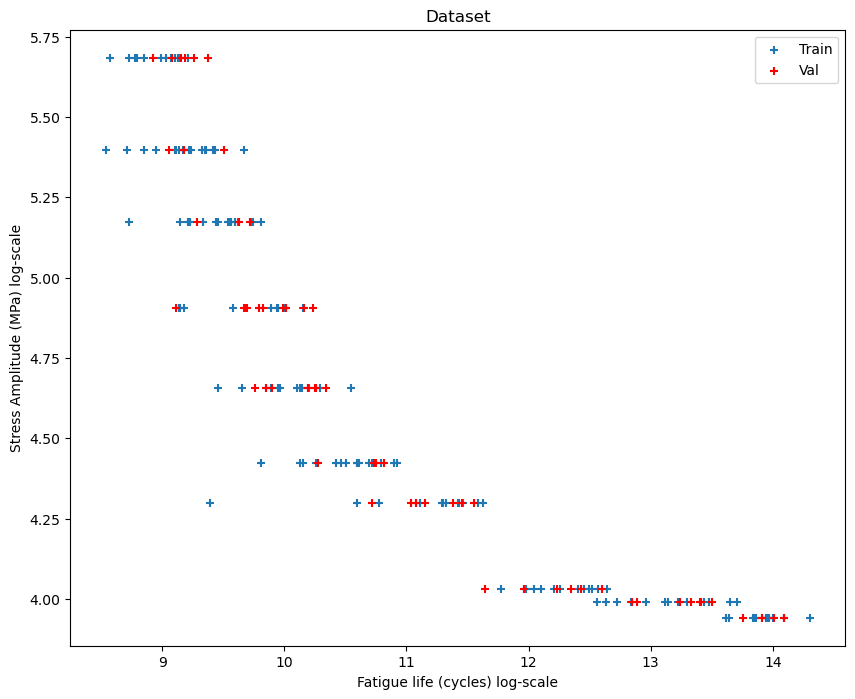

In [11]:
def plot_dataset(x_train, y_train, x_val, y_val, title):
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(y_train, x_train, marker='+', label='Train')
    plt.scatter(y_val, x_val, marker='+', color='r', label='Val')

    plt.title(title)
    plt.xlabel('Fatigue life (cycles) log-scale')
    plt.ylabel('Stress Amplitude (MPa) log-scale')
    plt.legend()
    plt.show()
    
plot_dataset(x_train, y_train, x_val, y_val, 'Dataset')

# Physics-Informed Neural Networks
## Neural Network

In [12]:
tfkl = tf.keras.layers
tfkm = tf.keras.models
tfpl = tfp.layers
tfd = tfp.distributions


def nn_architecture(lr,loss_function): 
    # Model Configuration
    model = tfkm.Sequential([
        tfkl.Dense(16, input_shape = (1,), activation='tanh'),
        tfkl.Dense(2), 
        tfpl.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :1], scale = (1e-3 + tf.math.softplus(t[..., 1:])))
            )
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  loss=loss_function, metrics=[keras.metrics.RootMeanSquaredError()])

    return model

def model_fit(model, x_train, y_train, x_val, y_val, epochs):
    set_seeds(42)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(x_train), seed=42, reshuffle_each_iteration=False)
    train_dataset = train_dataset.batch(30)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(30)

    # Early Stopping Callback
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, min_delta=0, mode='auto', 
                                                baseline=None, restore_best_weights=True)
    # Model Fitting
    history = model.fit(train_dataset, validation_data=val_dataset, 
                        epochs=epochs, verbose=False, callbacks=[callback])
    
    return model

## Physics-Informed

### Collocation point

In [13]:
x_collocation = tf.convert_to_tensor(np.linspace(df['stress_log_mpa'].min(), 
                                      df['stress_log_mpa'].max()+0.01, 1000).reshape(-1, 1), dtype=tf.float32)

In [14]:
# Define the penalty term for the physics constraint
def physics_penalty(x_collocation):
    with tf.GradientTape() as tape1:
        tape1.watch(x_collocation)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x_collocation)
            y_mean = tf.reduce_mean(model(x_collocation))
            y_std = tf.math.reduce_std(model(x_collocation))

        # Compute first derivative (mean and std)    
        dx_mean = tape2.gradient(y_mean, x_collocation)
        dx_std = tape2.gradient(y_std, x_collocation)
    
    # Compute second derivative    
    dx2 = tape1.gradient(dx_mean, x_collocation, unconnected_gradients='zero')
    
    n = x_collocation.shape[0]
    state_indicator_mean = tf.cast(dx_mean > 0, tf.float32)
    state_indicator_std = tf.cast(dx_std > 0, tf.float32)
    state_indicator_dx2 = tf.cast(dx2 < 0, tf.float32)
    
    lp2=tf.math.multiply(state_indicator_std, dx_std**2) / n
    lp1=tf.math.multiply(state_indicator_mean, dx_mean**2) / n
    lp3=tf.math.multiply(state_indicator_dx2, dx2**2) / n

    return tf.math.reduce_sum(lp1) + tf.math.reduce_sum(lp2) + tf.math.reduce_sum(lp3)

def custom_loss(y_true, y_pred, lambda_penalty, x_collocation):
    negloglik = -y_pred.log_prob(y_true)    
    return negloglik + lambda_penalty * physics_penalty(x_collocation)

In [15]:
class CustomLoss(Loss):
    def __init__(self, lambda_penalty, x_collocation):
        super().__init__()
        self.x_collocation = x_collocation
        self.lambda_penalty = lambda_penalty

    def call(self, y_true, y_pred):
        return custom_loss(y_true, y_pred, self.lambda_penalty, self.x_collocation)

## Training Neural Networks

In [16]:
def create_model(epochs, lr, lambda_penalty, x_collocation) :
    loss_fn = CustomLoss(lambda_penalty=lambda_penalty, x_collocation=x_collocation)
    model = nn_architecture(lr, loss_fn)
    return model

In [17]:
# Model Architecture
epochs = 3000 
lr = 5e-4
lambda_penalty = 1000

model = create_model(epochs, lr, lambda_penalty, x_collocation)
model = model_fit(model, x_train, y_train, x_val, y_val, epochs)

Random seed set as 42


In [18]:
predict_val = model.predict(x_val)
r2 = explained_variance_score(y_val, predict_val)
rmse = mean_squared_error(y_val, predict_val, squared=False)
mape = mean_absolute_percentage_error(y_val, predict_val)
print('R2: ', r2)
print('RMSE: ', rmse)
print('MAPE: ', mape)

2/2 [==============================] - 0s 1ms/step
R2:  0.6907461881637573
RMSE:  0.888911
MAPE:  0.053865172


/opt/homebrew/Caskroom/miniconda/base/envs/pfia_2024/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Visualisation des résultats

In [19]:
y_pred = model(x_test)

y_pred_mean = y_pred.mean()
y_pred_std = y_pred.stddev()

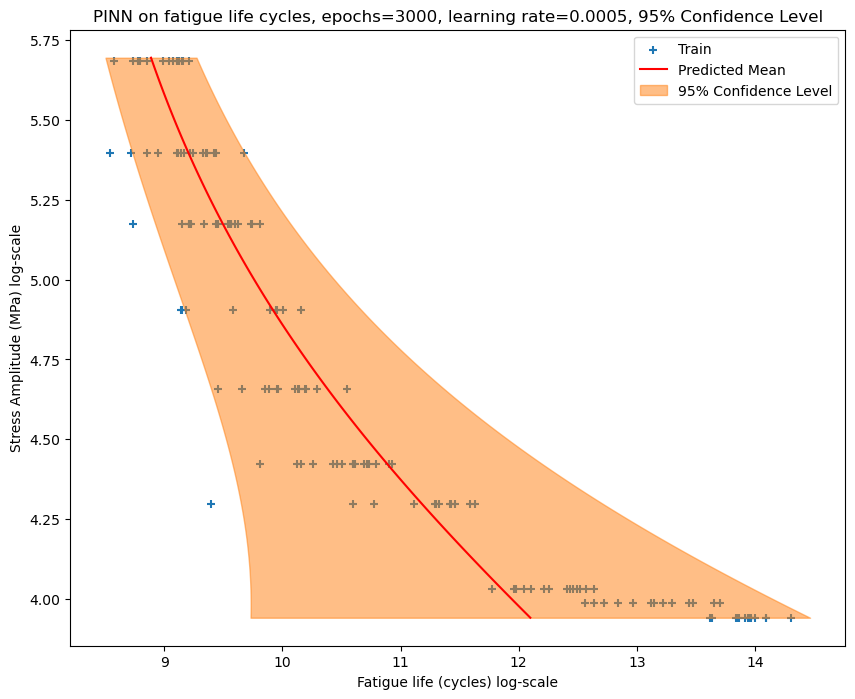

In [20]:
fig = plt.figure(figsize = (10, 8))
plt.scatter(y_train, x_train, marker='+', label='Train')
plt.plot(y_pred_mean, x_test, color='r', label='Predicted Mean')
plt.fill_betweenx(x_test.ravel(), np.array(y_pred_mean+1.96*y_pred_std).ravel(), np.array(y_pred_mean-1.96*y_pred_std).ravel(), x_test.ravel(), color='C1', alpha=0.5, label='95% Confidence Level')
plt.title(f'PINN on fatigue life cycles, epochs={epochs}, learning rate={lr}, 95% Confidence Level')
plt.xlabel('Fatigue life (cycles) log-scale')
plt.ylabel('Stress Amplitude (MPa) log-scale')
plt.legend()
plt.show()

Text(0, 0.5, 'Curvature')

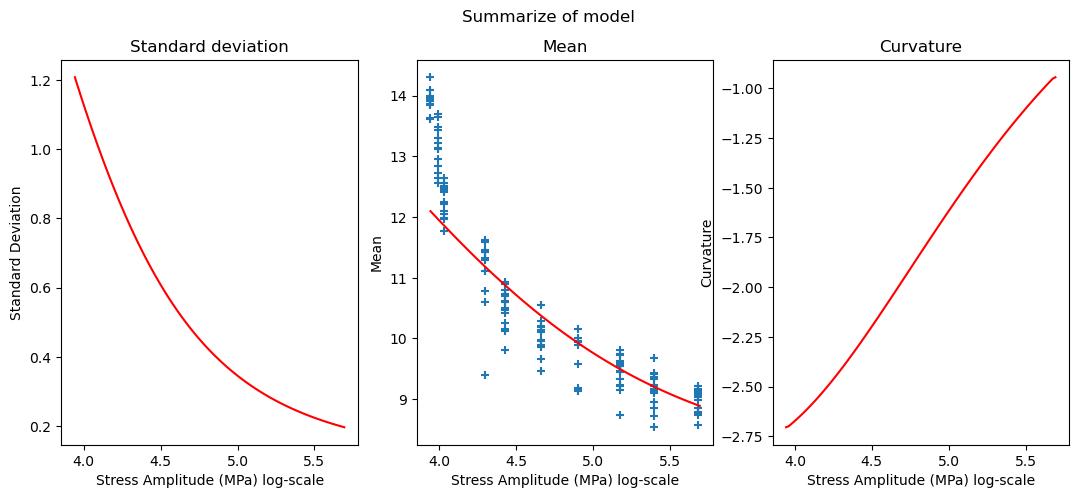

In [21]:
dx_dt = np.gradient(x_test[:, 0])
dy_dt = np.gradient(y_pred_mean[:, 0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5))
fig.suptitle('Summarize of model')
ax1.plot(x_test, y_pred_std, color='r', label='Predicted Standard Deviation')
ax1.title.set_text('Standard deviation')
ax1.set_xlabel('Stress Amplitude (MPa) log-scale')
ax1.set_ylabel('Standard Deviation')

ax2.plot(x_test, y_pred_mean, color='r', label='Predicted Mean')
ax2.scatter(x_train, y_train, marker='+', label='Train')
ax2.title.set_text('Mean')
ax2.set_xlabel('Stress Amplitude (MPa) log-scale')
ax2.set_ylabel('Mean')

ax3.plot(x_test, (dy_dt/dx_dt), color='r', label='Predicted Curvature')
ax3.title.set_text('Curvature')
ax3.set_xlabel('Stress Amplitude (MPa) log-scale')
ax3.set_ylabel('Curvature')

# Sauvegarder la figure dans un fichier PNG
#plt.savefig('img/results.png', format='png')

In [22]:
def evaluate_spearman_std(model, x_test):
    y_pred = model(x_test)
    y_pred_std = y_pred.stddev()
    
    spearman_std, p_value_std = spearmanr(x_test, y_pred_std)
    return spearman_std, p_value_std

def evaluate_spearman_mean(model, x_test):
    y_pred = model(x_test)
    y_pred_mean = y_pred.mean() 
    
    spearman_mean, p_value_mean = spearmanr(x_test, y_pred_mean)
    return spearman_mean, p_value_mean

def evaluate_spearman_curve(model, x_test):
    y_pred = model(x_test)
    y_pred_mean = y_pred.mean() 
    
    dx_dt = np.gradient(x_test[:, 0])
    dy_dt = np.gradient(y_pred_mean[:, 0])
    y_pred_curve = (dy_dt/dx_dt)

    spearman_curve, p_value_curve = spearmanr(x_test, y_pred_curve)
    return spearman_curve, p_value_curve 

In [23]:
spearman_mean, p_value_mean = evaluate_spearman_mean(model, x_test)
spearman_std, p_value_std = evaluate_spearman_std(model, x_test)
spearman_curve, p_value_curve = evaluate_spearman_curve(model, x_test)
print({'Spearman Std': spearman_std, 'p_value std': p_value_std, 'Spearman Mean': spearman_mean, 'p_value mean': p_value_mean, 'Spearman Curve': spearman_curve, 'p_value curve': p_value_curve})

{'Spearman Std': -0.9999999999999999, 'p_value std': 0.0, 'Spearman Mean': -0.9999999999999999, 'p_value mean': 0.0, 'Spearman Curve': 0.9999999999999999, 'p_value curve': 0.0}


# Evaluation of severals models

In [24]:
model_configs = [
    {'epochs': 250, 'lr': 5e-3, 'lambda': 0, 'x_collocation': x_collocation},
    {'epochs': 250, 'lr': 5e-3, 'lambda': 100000, 'x_collocation': x_collocation}
]

results = []

for i, config in enumerate(model_configs):
    model = create_model(config['epochs'], config['lr'], config['lambda'], config['x_collocation'])
    model = model_fit(model, x_train, y_train, x_val, y_val, config['epochs'])

    spearman_mean, p_value_mean = evaluate_spearman_mean(model, x_test)
    spearman_std, p_value_std = evaluate_spearman_std(model, x_test)
    spearman_curve, p_value_curve = evaluate_spearman_curve(model, x_test)
    results.append({'Model': f'Model {i+1}', 'Spearman Std': spearman_std, 'p_value std': p_value_std, 'Spearman Mean': spearman_mean, 'p_value mean': p_value_mean, 'Spearman Curve': spearman_curve, 'p_value curve': p_value_curve})
    tf.keras.backend.clear_session()

results_df = pd.DataFrame(results)

results_df

Random seed set as 42


Random seed set as 42


,Model,Spearman Std,p_value std,Spearman Mean,p_value mean,Spearman Curve,p_value curve
0,Model 1,-1.0,0.0,-1.0,0.0,-0.548158,3.564739e-09
1,Model 2,-1.0,0.0,-1.0,0.0,0.940630,8.816948e-48
